In [31]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(int), X.reshape(-1, 784).astype(np.float32)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

In [24]:
EPOCHS=300
BATCH_SIZE=64
ACTIVATIONS = [torch.nn.Sigmoid, torch.nn.Tanh, torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.ELU, torch.nn.GELU, torch.nn.Softplus]

accuracy = lambda prediction, target: np.sum(np.argmax(prediction, axis=1) == target) / target.shape[0]
lossFn = torch.nn.CrossEntropyLoss()

In [25]:
train_loss, train_acc, test_loss, test_acc = {}, {}, {}, {}

for activation_fn in ACTIVATIONS:
    activation_name = activation_fn.__name__
    train_loss[activation_name] = []
    train_acc[activation_name] = []
    test_loss[activation_name] = []
    test_acc[activation_name] = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        activation_fn(),
        torch.nn.Linear(128, 10),
        torch.nn.Softmax(dim=1)
    )
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in progressbar(range(EPOCHS)):
        order = np.random.permutation(train_data.shape[0])
        train_x = train_data[order]
        train_y = train_target[order]
        loss_agg = 0
        for i in range(0, train_x.shape[0] // BATCH_SIZE):
            batch_x = train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            batch_y = train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    
            optimizer.zero_grad()
            output = model(torch.from_numpy(batch_x))
            loss = lossFn(output, torch.from_numpy(batch_y))
            loss.backward()
            optimizer.step()
            
            loss_agg += loss.item()
            
        with torch.no_grad():
            train_output = model(torch.from_numpy(train_data))
            test_output = model(torch.from_numpy(test_data))
            train_loss[activation_name].append(loss_agg)
            train_acc[activation_name].append(accuracy(train_output.numpy(), train_target))
            test_loss[activation_name].append(lossFn(test_output, torch.from_numpy(test_target)).item())
            test_acc[activation_name].append(accuracy(test_output.numpy(), test_target))

100% (300 of 300) |######################| Elapsed Time: 0:03:40 Time:  0:03:400218
100% (300 of 300) |######################| Elapsed Time: 0:03:35 Time:  0:03:350218
100% (300 of 300) |######################| Elapsed Time: 0:03:26 Time:  0:03:260217
100% (300 of 300) |######################| Elapsed Time: 0:03:40 Time:  0:03:400218
100% (300 of 300) |######################| Elapsed Time: 0:03:21 Time:  0:03:210216
100% (300 of 300) |######################| Elapsed Time: 0:03:34 Time:  0:03:340217
100% (300 of 300) |######################| Elapsed Time: 0:03:24 Time:  0:03:240217


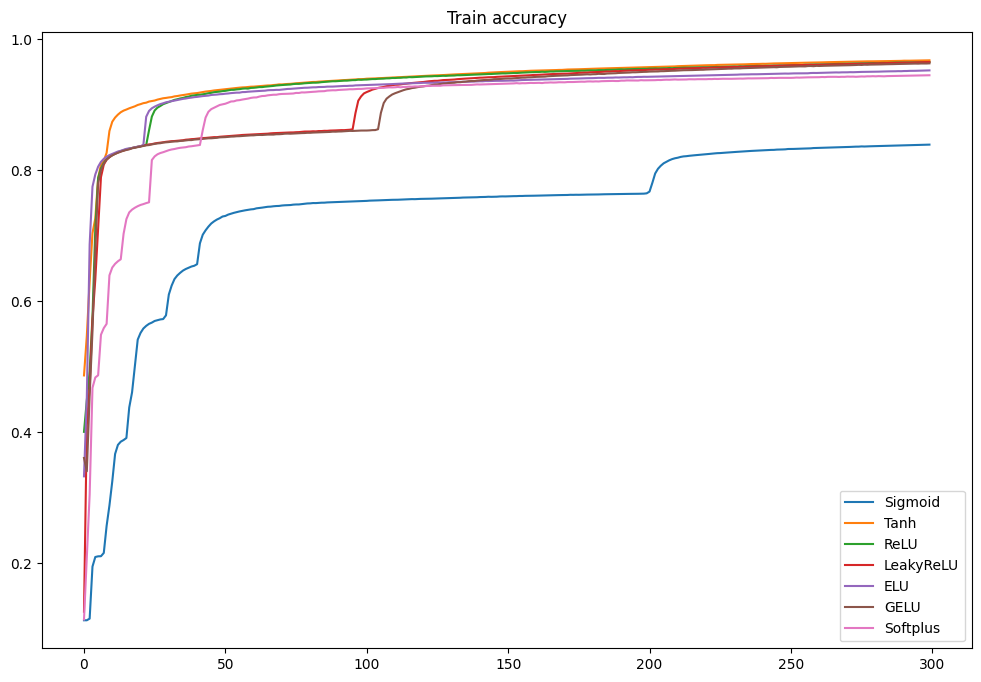

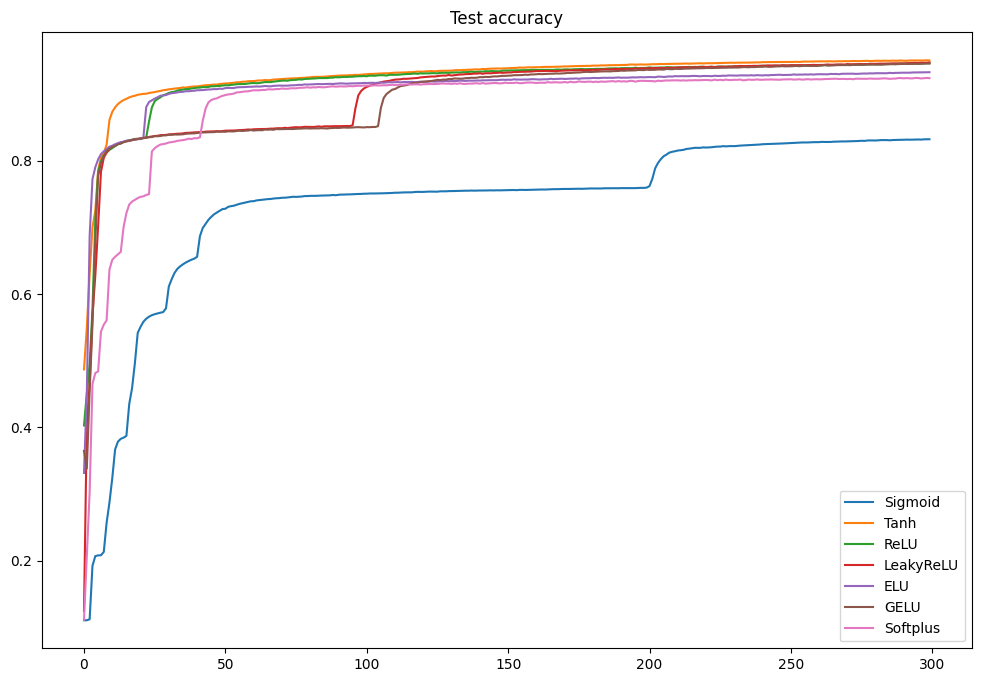

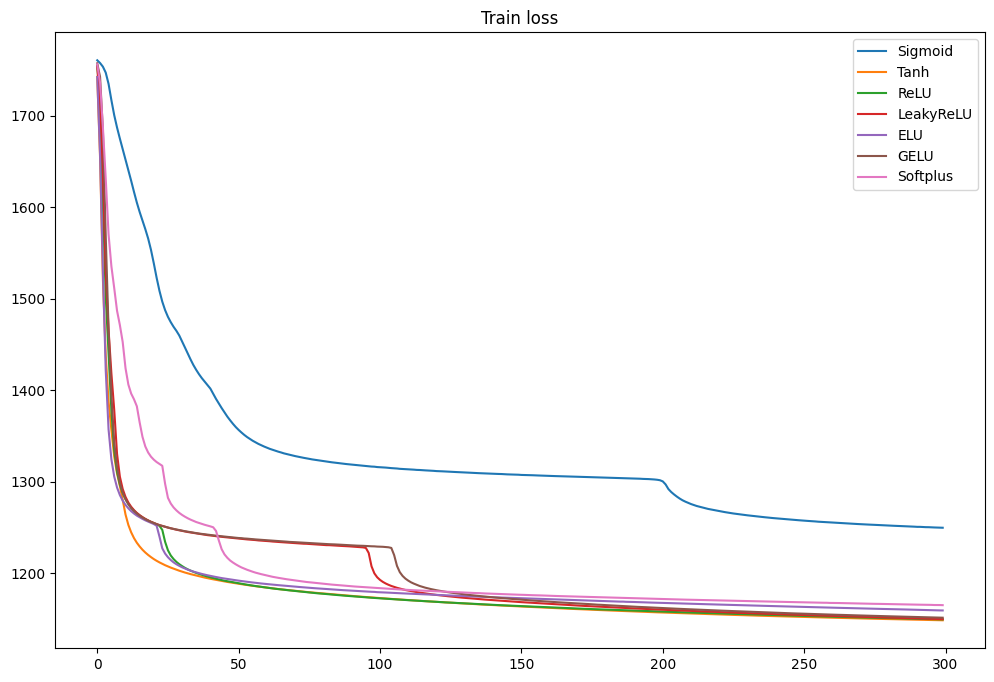

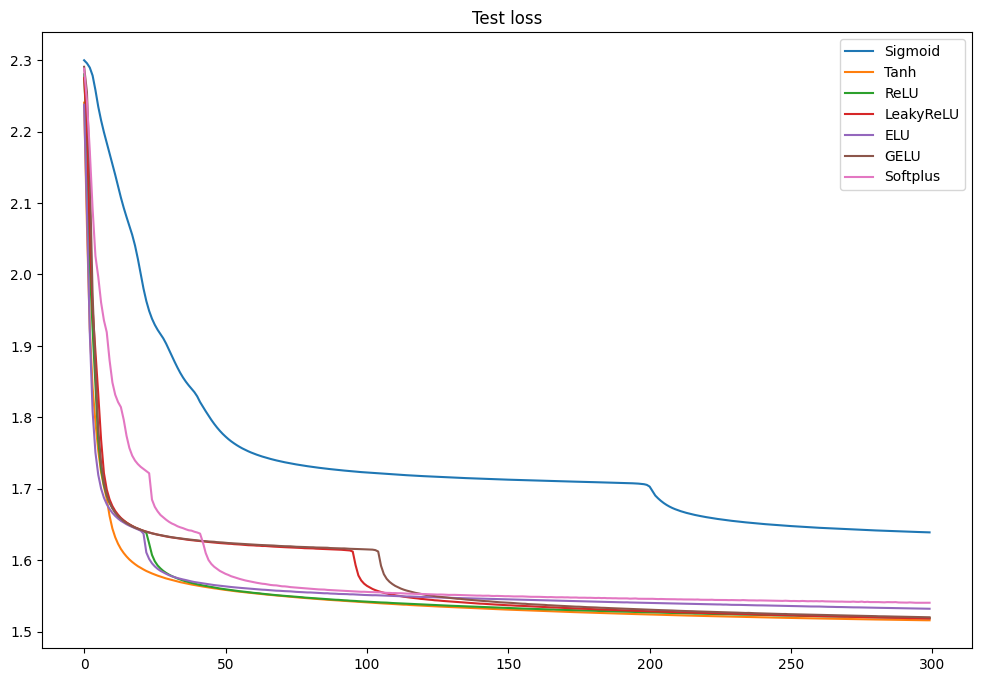

In [34]:
plt.figure(figsize=(12, 8))
plt.title('Train accuracy')
for activation_fn in ACTIVATIONS:
    plt.plot(train_acc[activation_fn.__name__], label=activation_fn.__name__)
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Test accuracy')
for activation_fn in ACTIVATIONS:
    plt.plot(test_acc[activation_fn.__name__], label=activation_fn.__name__)
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Train loss')
for activation_fn in ACTIVATIONS:
    plt.plot(train_loss[activation_fn.__name__], label=activation_fn.__name__)
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Test loss')
for activation_fn in ACTIVATIONS:
    plt.plot(test_loss[activation_fn.__name__], label=activation_fn.__name__)
plt.legend()
plt.show()